In [610]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import bids
import mne
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

import sys
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')

from scv_funcs import lfpca, utils
import neurodsp as ndsp
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size']=15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Should add this to LFPCA module

In [645]:
def plot_complex(ft, plot_single=True, plot_mean=True, mc='k',ms=5,alpha=0.8):
    if plot_single:
        plt.plot(ft.real,ft.imag,'.', color=mc, alpha=alpha)
    if plot_mean:
        cplx_mean = ft.mean()
        plt.plot(cplx_mean.real,cplx_mean.imag,'*', ms=ms, color=mc) 
        plt.gcf().gca().add_artist(plt.Circle((cplx_mean.real,cplx_mean.imag), (np.abs(ft)**2).mean()**0.5, color=mc, fill=False))    

In [236]:
subj, sess, run = '01', '01', 1
layout = bids.layout.BIDSLayout('/Users/rdgao/Documents/data/Hermes/')
f_raw = layout.get(return_type='object', suffix='ieeg', subject=subj, session=sess, run=run, extensions='.vhdr')[0]
f_events = layout.get(return_type='object', suffix='events', subject=subj, session=sess, run=run)[0]
f_channels = layout.get(return_type='object', suffix='channels', subject=subj, session=sess, run=run)[0]
f_elec = layout.get(return_type='object', suffix='electrodes', subject=subj, session=sess)[0]

events = pd.read_csv(f_events.path, delimiter='\t')
chan_info = pd.read_csv(f_channels.path, delimiter='\t')
elec_loc = pd.read_csv(f_elec.path, delimiter='\t').apply(pd.to_numeric, errors='coerce')

In [237]:
layout.get_metadata(f_raw.path)

{'ECGChannelCount': 0,
 'ECOGChannelCount': 118,
 'EEGChannelCount': 0,
 'EMGChannelCount': 0,
 'EOGChannelCount': 0,
 'ElectrodeManufacturer': 'AdTech',
 'EpochLength': 0,
 'HardwareFilters': ['highpass', '0.5', 'lowpass', '300'],
 'InstitutionAddress': '300 Pasteur Dr, Stanford, CA 94305',
 'InstitutionName': 'Stanford Hospital and Clinics',
 'Instructions': 'look at the dot in the center of the screen and press the button when it changes color',
 'Manufacturer': 'Tucker Davis Technologies',
 'MiscChannelCount': 0,
 'PowerLineFrequency': 60,
 'RecordingDuration': 233.639,
 'RecordingType': 'continuous',
 'SEEGChannelCount': 0,
 'SamplingFrequency': 3051.76,
 'SoftwareFilters': 'n/a',
 'TaskDescription': 'visual gratings and noise patterns',
 'TaskName': 'visual',
 'TriggerChannelCount': 0,
 'iEEGPlacementScheme': 'right occipital temporal surface',
 'iEEGReferenceScheme': 'intracranial channel not included with data'}

In [238]:
raw = mne.io.read_raw_brainvision(f_raw.path, preload=True)
raw.info
data, t = raw[:,:]
data = data[:-1,:]

Extracting parameters from /Users/rdgao/Documents/data/Hermes/sub-01/ses-01/ieeg/sub-01_ses-01_task-visual_run-01_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 713009  =      0.000 ...   233.620 secs...


# SCV over whole recording

In [239]:
fs = 1./np.diff(t).mean()
params = {'nperseg':int(fs), 'noverlap':0, 'spg_outlierpct':1, 'max_freq':250}
lf = lfpca.LFPCA(params)
lf.populate_ts_data(data,fs)
lf.compute_all_spectral()
lf.compute_KS_expfit()

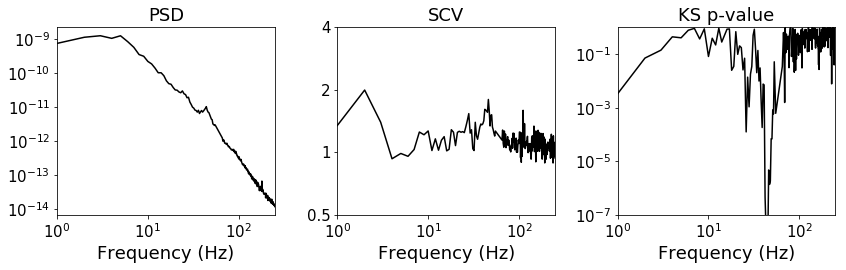

In [646]:
good_chans = np.where(chan_info['status']=='good')[0]
plt.figure(figsize=(12,4))
lf.plot_spectral(plot_mean=False, plot_chan=chan, exc_freqs=[[56,65]])

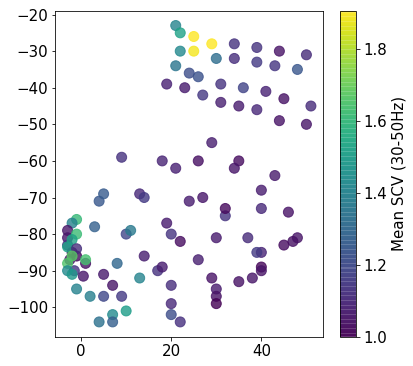

In [611]:
f_range = (30,50)
scv_mean = lf.scv[good_chans,f_range[0]:f_range[1]].mean(axis=1)
plt.figure(figsize=(6,6))
plt.scatter(elec_loc['x'][good_chans], elec_loc['y'][good_chans], s=100, c=scv_mean, alpha=0.8)
plt.colorbar(label='Mean SCV (%i-%iHz)'%f_range)

# Epoched data analysis

In [321]:
window = (int(fs*0),int(fs*0.5))
trial_inds = np.array(events['onset']*fs).astype(int)
data_epoched = utils.grab_stack_epochs(data,trial_inds,window, axis=1)
epoch_len = data_epoched.shape[1]

In [365]:
n_chans, f_lim, n_ft = data.shape[0], 300, int(fs)
window = sp.signal.windows.hamming(epoch_len)
data_win = data_epoched*window[np.newaxis, :, np.newaxis]

# precompute per-trial PSD, use n=fs for FFT to get 1Hz spacing
ft = np.fft.fft(data_win, n=n_ft, axis=1)
f_axis = np.fft.fftfreq(n_ft, 1/fs)
f_axis = f_axis[:np.where(np.abs(f_axis)>f_lim)[0][0]]
psd = (np.abs(ft)**2.)[:,:len(f_axis),:]

/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


In [569]:
# load into LFPCA objects
tr_types = events['trial_type'].unique()
lf_tr = []
for i,tt in enumerate(tr_types):
    print(i)
    lf_tr.append(lfpca.LFPCA({'nperseg':n_ft, 'noverlap':0, 'spg_outlierpct':1, 'max_freq':250}))
    lf_tr[i].populate_fourier_data(psd[:,:,events.trial_type==tt], fs, f_axis)
    lf_tr[i].compute_KS_expfit()

lf_tr.append(lfpca.LFPCA({'nperseg':n_ft, 'noverlap':0, 'spg_outlierpct':1, 'max_freq':250}))
lf_tr[-1].populate_fourier_data(psd[:,:,:], fs, f_axis)
lf_tr[-1].compute_KS_expfit()

0
1
2
3
4
5
6
7


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


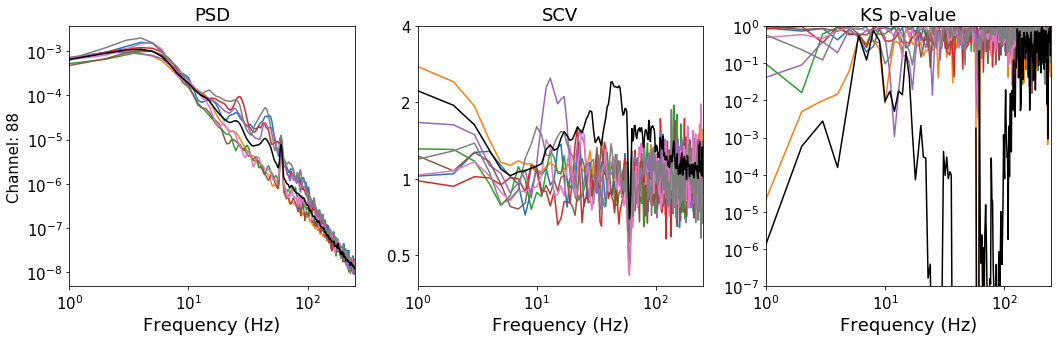

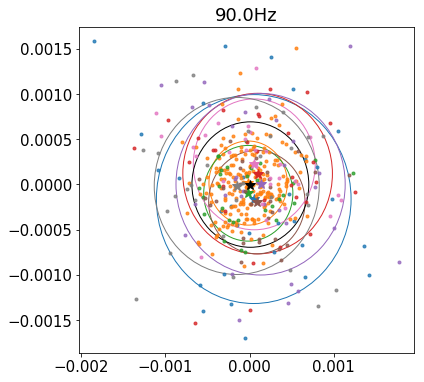

In [644]:
chan = 88
fr = 90
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(tr_types)]
plt.figure(num=1, figsize=(15,5))
plt.figure(num=2, figsize=(6,6))
for i,tt in enumerate(tr_types):
    plt.figure(1)
    lf_tr[i].plot_spectral(plot_mean=False, plot_chan=chan, plot_color=CKEYS[i])

    plt.figure(2)
    plot_complex(ft[chan,fr,events.trial_type==tt], mc=CKEYS[i], ms=10)

plt.figure(1)
lf_tr[-1].plot_spectral(plot_mean=False, plot_chan=chan, plot_color='k')
plt.subplot(1,3,1)
plt.ylabel('Channel: %i'%chan)
plt.tight_layout()
plt.figure(2)
plot_complex(ft[chan,fr,:], plot_single=False, mc='k', ms=10)
plt.title('%.1fHz'%f_axis[fr]);